In [1]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
plt.style.use(['science','notebook'])

# Phase Field Crystal equation

The free-energy is defined as 

$$ F[c] = \int_V dx \left[ \frac{\kappa}{2}\left(\nabla c\right)^2 +f(c) \right]$$

where the free-energy density is

$$f(c) = W c^2(1-c)^2$$

The conservation equation is obtained by the flux $\boldsymbol{j} = -M \nabla(\delta F/\delta c)$, such that

$$\frac{\partial c}{\partial t} = M \left[ - \kappa \nabla^4 c+ \nabla^2 f'  \right] $$

onde $f' = df/dc$

In [2]:
# def calculate_nonlinear_terms(n,dt,method='euler'):
#     if method == 'euler':
#         return Noperator_func(n)
#     elif method == 'leapfrog':
#         n_hat_star = fft2(n)
#         n_hat_star[:] += 0.5*dt*Noperator_func(n)
#         return Noperator_func(ifft2(n_hat_star).real)
#     elif method == 'rk4':
#         K1 = Noperator_func(n)
#         n_hat_star = fft2(n)
#         n_hat_star[:] += 0.5*dt*K1
#         K2 = Noperator_func(ifft2(n_hat_star).real)
#         n_hat_star[:] += 0.5*dt*(K2-K1)
#         K3 = Noperator_func(ifft2(n_hat_star).real)
#         n_hat_star[:] += dt*(K3-0.5*K2)
#         K4 = Noperator_func(ifft2(n_hat_star).real)
#         return (1.0/6.0)*(K1+2*K2+2*K3+K4)

In [3]:
import numpy as np
from scipy.fft import fft2, ifft2
# PFC model constants
r = -0.25
M = 1.0 # mobility
# Size of the system
N = 2**8 # 2**8 = 256
L = 16*np.pi
x = np.linspace(0,L,N)
dx = x[1]-x[0]
# The time step definition
dt = 0.1
T = 3000
Nsteps = int(T/dt)
Nframes = Nsteps//100 #frames to the output
# The vector of variables
n_hat = np.empty((N,N), dtype=np.complex64)
n = np.empty((Nframes,N,N), dtype=np.float32)
# Initial condition
rng = np.random.default_rng(12345)
noise = 0.02*0.285
n0 = -0.285
n[0] = n0 + noise*rng.standard_normal(n[0].shape)
# The Fourier variables and dealising vector
kx = np.fft.fftfreq(N, d=dx)*2*np.pi
k = np.array(np.meshgrid(kx , kx ,indexing ='ij'), dtype=np.float32)
k2 = np.sum(k*k,axis=0, dtype=np.float32)
kmax_dealias = kx.max()*2.0/3.0 # The Nyquist mode
dealias = np.array((np.abs(k[0]) < kmax_dealias )*(np.abs(k[1]) < kmax_dealias ),dtype =bool)
# The linear terms of PDE
L_operator = -M*k2*(k2**2-2*k2+1+r)
# The non-linear terms of PDE (with dealising)
def Noperator_func(n):
    return -(k2*M*fft2(n**3))*dealias
# auxiliary variables
explinear_hat = np.exp(dt*L_operator) # can be calculated once
Noperator_hat = n_hat.copy()
# time evolution loop
nn = n[0].copy()
n_hat[:] = fft2(n[0]) # FT initial condition
for i in range(1,Nsteps):
    Noperator_hat[:] = Noperator_func(nn) # calculate the non-linear term
    n_hat[:] = (n_hat+dt*Noperator_hat)*explinear_hat # updating in time
    nn[:] = ifft2(n_hat).real # IFT to next step
    if (i//100): 
        n[i//100] = nn

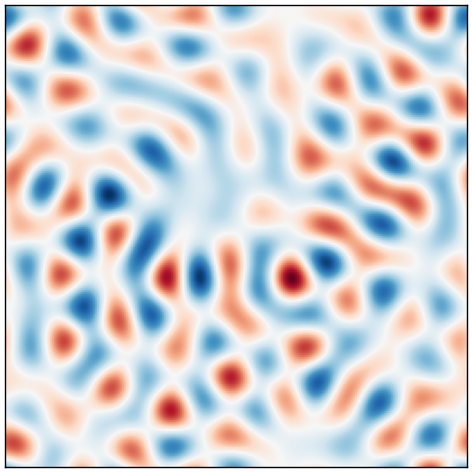

In [4]:
plt.imshow(n[1],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('crystal-t=10.pdf')

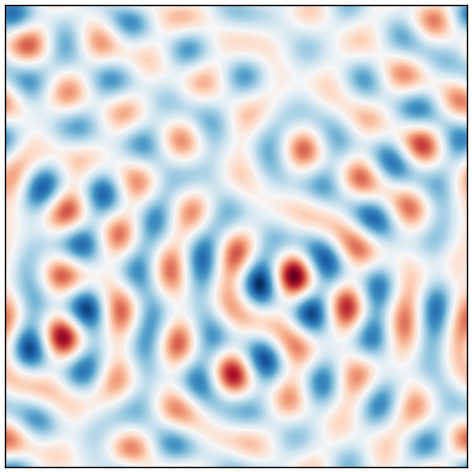

In [5]:
plt.imshow(n[10],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('crystal-t=100.pdf')

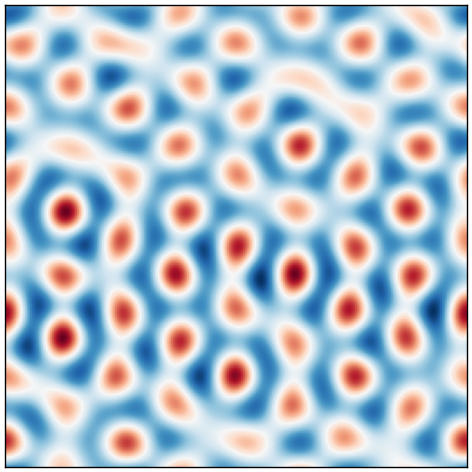

In [6]:
plt.imshow(n[100],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('crystal-t=1000.pdf')

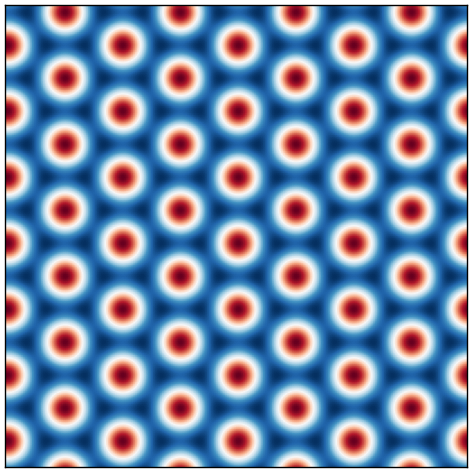

In [7]:
plt.imshow(n[-1],cmap='RdBu_r')
plt.xticks([])
plt.yticks([])
plt.savefig('crystal-t=3000.pdf')

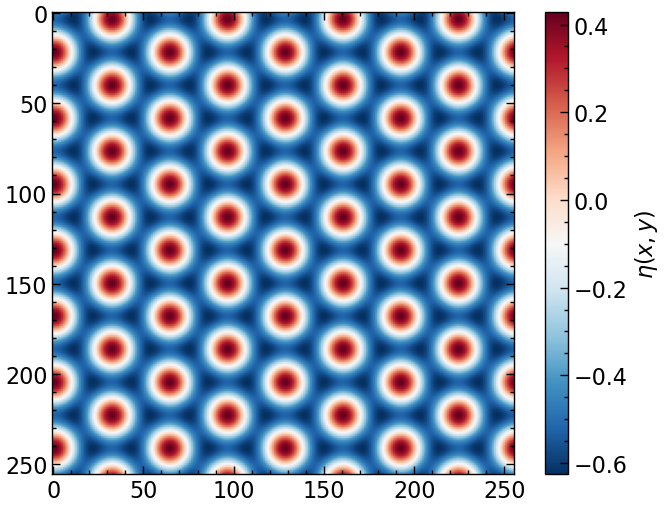

In [8]:
plt.imshow(n[-1],cmap='RdBu_r')
plt.colorbar(label=r'$\eta(x,y)$')

In [9]:
L = N*dx
N0 = n[0].sum()*dx**2/L**2
Nlast = n[-1].sum()*dx**2/L**2

print(np.abs(Nlast/N0-1))

1.0457993171453239e-07


In [10]:
n[-1].min(), n[-1].max()

(-0.62547785, 0.42831907)

## Generate video MP4

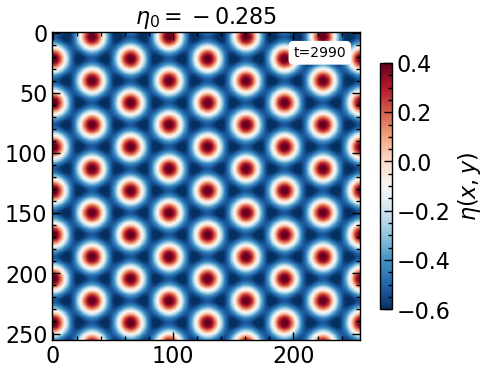

In [11]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
im = ax.imshow(n[0],cmap='RdBu_r', vmin=-0.6, vmax=0.4)
# im = ax.imshow(n[0],cmap='RdBu_r')
cb = fig.colorbar(im,ax=ax, label=r'$\eta(x,y)$', shrink=0.8)
tx = ax.text(200,20,'t={:.1f}'.format(0.0),
         bbox=dict(boxstyle="round",ec='white',fc='white'))
ax.set_title(r'$\eta_0=%.3f$'% n0)

def animate(i):
    im.set_data(n[i])
    tx.set_text('t={:.0f}'.format(i*dt*100))
    return fig,

ani = animation.FuncAnimation(fig, animate, frames= Nframes,
                               interval = 50)
writervideo = animation.FFMpegWriter(fps=30) 
ani.save('pfc2d-crystal.mp4',writer=writervideo,dpi=200)

## Generate GIF

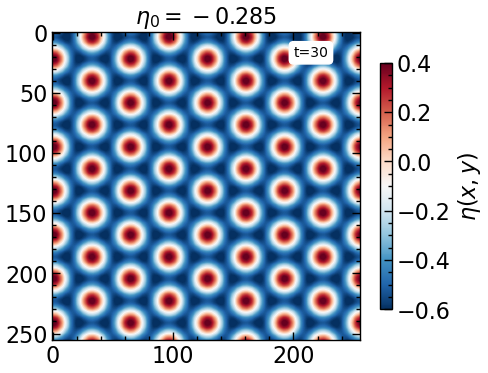

In [12]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
im = ax.imshow(n[0],cmap='RdBu_r', vmin=-0.6, vmax=0.4)
cb = fig.colorbar(im,ax=ax, label=r'$\eta(x,y)$', shrink=0.8)
tx = ax.text(200,20,'t={:.1f}'.format(0.0),
         bbox=dict(boxstyle="round",ec='white',fc='white'))
ax.set_title(r'$\eta_0=%.3f$'% n0)

frames = 100
nsteps = int(Nframes/frames)
nshift = Nframes-1-nsteps*(frames-1)

def animate(i):
    im.set_data(n[nsteps*i+nshift])
    tx.set_text('t={:.0f}'.format((nsteps*i+nshift)*dt))
    return fig,

ani = animation.FuncAnimation(fig, animate, frames= frames,
                               interval = 50)
ani.save('pfc2d-crystal.gif',writer='pillow',fps=10,dpi=100)

In [13]:
F = np.zeros(Nframes)
t = np.linspace(0.0,Nsteps*dt,Nframes)
lapn = np.empty((N,N), dtype=np.float32)
laplapn = np.empty((N,N), dtype=np.float32)
for i in range(t.size):
    n_hat[:] = fft2(n[i])
    lapn[:] = ifft2(-k2*n_hat).real
    laplapn[:] = ifft2(k2**2*n_hat).real
    F[i] = np.sum(n[i]*(lapn+0.5*laplapn)+0.5*(1+r)*n[i]**2 + 0.25*n[i]**4)*dx**2

In [14]:
L

50.46260199648546

## Semi-implicit method

In [15]:
lineardenominator_hat = 1.0/(1.0-dt*L_operator) # can be calculated once
Noperator_hat = n_hat.copy()
# time evolution loop
nn = n[0].copy()
n_hat[:] = fft2(n[0]) # FT initial condition
for i in range(1,Nsteps):
    Noperator_hat[:] = Noperator_func(nn) # calculate the non-linear term
    n_hat[:] = (n_hat+dt*Noperator_hat)*lineardenominator_hat # updating in time
    nn[:] = ifft2(n_hat).real # IFT to next step
    if (i//100): 
        n[i//100] = nn

In [16]:
N0 = n[0].sum()*dx**2/L**2
Nlast = n[-1].sum()*dx**2/L**2

print(np.abs(Nlast/N0-1))

0.0


In [93]:
N//2+22

150

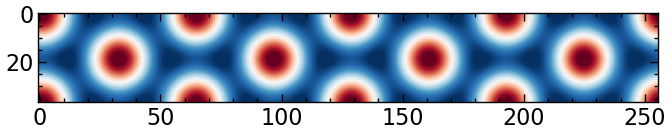

In [85]:
plt.imshow(n[-1,131:168],cmap='RdBu_r', vmin=-0.6, vmax=0.4)
# plt.colorbar(label=r'$\eta$')

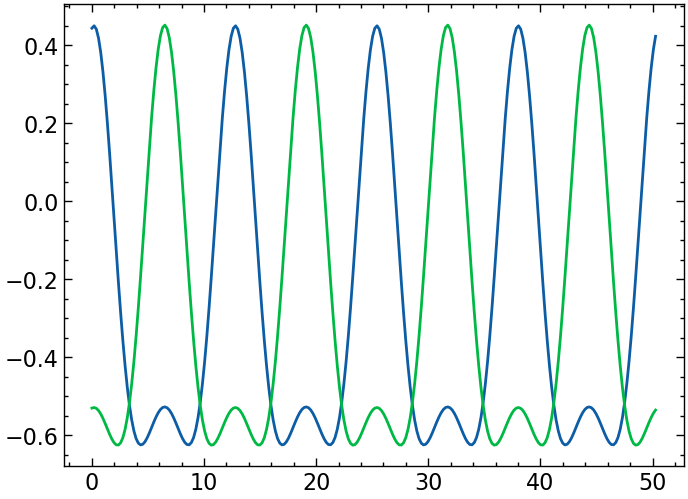

In [87]:
plt.plot(x,n[-1,N//2+3])
plt.plot(x,n[-1,N//2+22])
# plt.plot(x,n[-1,N//2+4])
# plt.plot(x,n[-1,N//2+5])

In [94]:
dx*(N//2+3)/L,dx*150/L

(0.51171875, 0.5859375)

In [95]:
h=-dx*131/L+dx*149.5/L
h

0.072265625

In [96]:
h/np.cos(np.pi/3)

0.14453124999999997

In [97]:
1/(4*np.sqrt(3))

0.14433756729740646

In [77]:
np.save('profile-pfc2d-crystal.npy',[x,n[-1,N//2+3]])
np.save('profile2-pfc2d-crystal.npy',[x,n[-1,N//2+22]])

In [20]:
Fsemi = np.zeros(Nframes)
for i in range(Nframes):
    n_hat[:] = fft2(n[i])
    lapn[:] = ifft2(-k2*n_hat).real
    laplapn[:] = ifft2(k2**2*n_hat).real
    Fsemi[i] = np.sum(n[i]*(lapn+0.5*laplapn)+0.5*(1+r)*n[i]**2 + 0.25*n[i]**4)*dx**2

In [21]:
np.save('free-energy-pfc2d-crystal.npy',[t,F])
np.save('free-energy-pfc2d-crystal-semiimplicit.npy',[t,Fsemi])

Text(2000, 0.032, '$\\eta_0=-0.285$')

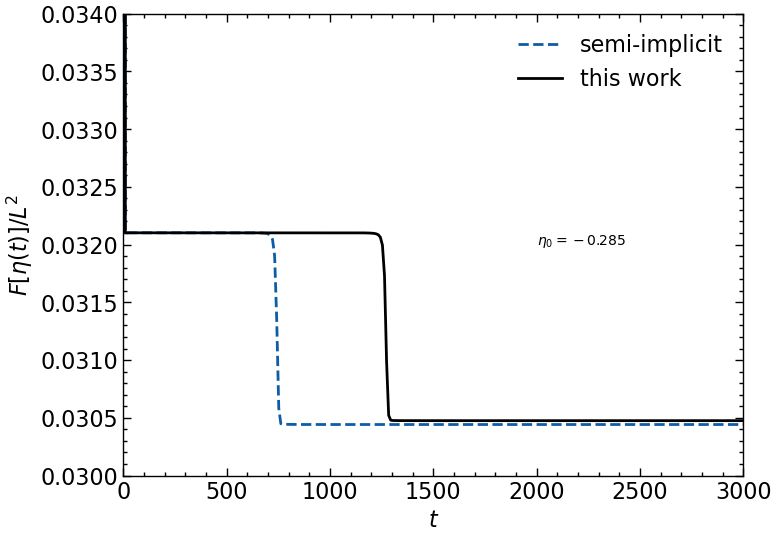

In [22]:
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0,3000)
plt.ylim(0.03,0.034)
plt.plot(t,Fsemi/L**2,'--',label='semi-implicit')
plt.plot(t,F/L**2,'k',label='this work')
plt.legend(loc='best')
plt.xlabel('$t$')
plt.ylabel('$F[\eta(t)]/L^2$')
plt.text(2000,0.032,'$\eta_0=-0.285$')